## 1.

Here is the Permutation-based Variable Importance plot calculated for the Random Forest (from sklearn) model.

As we can see, the `thall` is the most important variable, followed by `cp_0` and `thalchh`.


| Variable Importance  |
|----------------------|
| ![](imgs/1/pvi.png)  |


## 2.
Here are the PVI for 3 different models:
 - Random Forest with n_estimators=10 (instead of default 100)
 - Random Forest with n_estimators=2
 - Linear Classifier model

All those 3 models have lower auc and acc then original model. Mostly because they have smaller power of expression, they can not model the world accurately.

The PVI for all Random Forest models (original and two new ones) are quite similar. The PVI mostly differs on the `exng` variable - better model does not think it is important, smaller ones place this variable at the second and the fourth place.

The third model is much different. It also looks at variables like `trtbps`, `sex`. That's a small surprise, logistic regression is completely different from random forests.


| Random Forest, n_estimators=10 | Random Forest, n_estimators=2 | Linear Classifier                |
|--------------------------------|-------------------------------|----------------------------------|
| ![](imgs/2/model_10-pvi.png)   | ![](imgs/2/model_2-pvi.png)   | ![](imgs/2/model_linear-pvi.png) |


## 3.
Here is the comparison between the original PVI, feature importances from sklearn (Gini impurity) and SHAP variable importance (based on the TreeSHAP).

Surprisingly, the results are quite similar between those 3 completely different methods. There are of course differences, but for example `thalchh` is in top 3 important variables in all 3 methods.

| Original PVI        | Feature Importances (sklearn)       | SHAP                 |
|---------------------|-------------------------------------|----------------------|
| ![](imgs/1/pvi.png) | ![](imgs/3/feature_importances.png) | ![](imgs/3/shap.png) |



# Appendix

## 0.
Here the data is loaded (same as in previous homework) and a simple model is trained and evaluated. It is Random Forest Classifier from sklearn with default parameters.

Loading and preparing the data consists of:
- one hot encoding (models like logistic regression require this)
- splitting between target (y) and x

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
import dalex as dx


np.random.seed(42)


def load_data():
    df = pd.read_csv('heart.csv')

    # One hot encoding (for linear classifier)
    df = pd.get_dummies(df, columns=['caa', 'cp', 'restecg'])

    # Get targets
    y_all = df['output'].to_numpy()

    x_all = df.drop(columns=['output'])

    # Split data to train and test
    return train_test_split(x_all, y_all, test_size=0.2, random_state=42)


x_train, x_test, y_train, y_test = load_data()
print(f"{x_train.shape=}", f"{x_test.shape=}", f"{y_train.shape=}", f"{y_test.shape=}")

x_train.shape=(242, 22) x_test.shape=(61, 22) y_train.shape=(242,) y_test.shape=(61,)


Training the models

In [2]:
def get_model(verbose=False, model=None, n_estimators=100):
    if model is None:
        model = RandomForestClassifier(n_estimators=n_estimators)
    metrics = {
        "auc": roc_auc_score,
        "accuracy": accuracy_score
    }
    model.fit(x_train, y_train)
    pred_test = model.predict(x_test)
    if verbose:
        print({metric_name: metric_fun(y_test, pred_test) for metric_name, metric_fun in metrics.items()})

    return model

model = get_model(True)
model_10 = get_model(True, n_estimators=10)
model_2 = get_model(True, n_estimators=2)
model_linear = get_model(True, LogisticRegression())

{'auc': 0.8841594827586207, 'accuracy': 0.8852459016393442}
{'auc': 0.8216594827586207, 'accuracy': 0.819672131147541}
{'auc': 0.7607758620689655, 'accuracy': 0.7540983606557377}
{'auc': 0.8685344827586206, 'accuracy': 0.8688524590163934}


## 1 & 2.

In [22]:
def pf_xgboost_classifier_categorical(model, df):
    df.loc[:, df.dtypes == 'object'] =\
        df.select_dtypes(['object'])\
        .apply(lambda x: x.astype('category'))
    return model.predict_proba(df)[:, 1]

def save_plot(_model, name):
    explainer = dx.Explainer(_model, x_test, y_test, predict_function=pf_xgboost_classifier_categorical, verbose=False)
    explainer.model_parts(random_state=0).plot(show=False).write_image(f"imgs/{name}")

save_plot(model, "1/pvi.png")
save_plot(model_2, "2/model_2-pvi.png")
save_plot(model_10, "2/model_10-pvi.png")
save_plot(model_linear, "2/model_linear-pvi.png")

## 3.

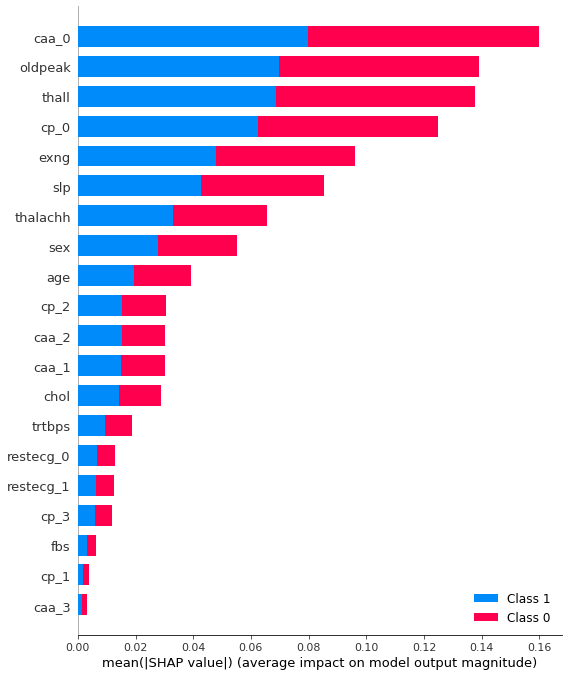

In [30]:
df = pd.DataFrame({"x": x_train.columns, "y": model.feature_importances_})
df = df.sort_values("y", ascending=False)
px.bar(df, x="x", y="y").write_image(f"imgs/3/feature_importances.png")

explainer = dx.Explainer(model, x_test, y_test, verbose=False)
pvi = explainer.model_parts(type="shap_wrapper", shap_explainer_type="TreeExplainer", check_additivity=False)
pvi.plot()
